# **Taller: Detección de Aviones**

# **Modelo para la localización de objetos**

**Descarga de dataset y etiquetas**

1. Carga del CSV

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = '/content/drive/MyDrive/EAFIT/Semestre3/Visualizacion_de_datos/Talleres/Airplanes'

In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
import tensorflow as tf

csv_path = f'{data_dir}/Airplanes.csv'
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,Image,x_top,y_top,x_bottom,y_bottom,label
0,0,image_0001.jpg,30,137,49,349,Airplanes
1,0,image_0002.jpg,35,153,59,342,Airplanes
2,0,image_0003.jpg,36,135,47,331,Airplanes
3,0,image_0004.jpg,24,141,47,342,Airplanes
4,0,image_0005.jpg,18,146,48,339,Airplanes


In [4]:
print(df.columns)

Index(['Unnamed: 0', 'Image', 'x_top', 'y_top', 'x_bottom', 'y_bottom',
       'label'],
      dtype='object')


In [5]:
img_dir = f'{data_dir}/airplanes'

**Implementación BBOX en formato COCO**

In [6]:
def hybrid_bbox_conversion(x_top, y_top, x_bottom, y_bottom, mode='train'):
    """
    Versión híbrida que:
    - Para entrenamiento (mode='train'): usa formato compatible con el modelo
    - Para visualización (mode='visualize'): usa formato correcto para mostrar
    """
    if mode == 'train':
        # Versión que funciona para el modelo
        x = x_bottom
        y = x_top
        width = y_bottom - x_bottom
        height = y_top - x_top
    else:
        # Versión correcta para visualización
        x = min(x_top, x_bottom)
        y = min(y_top, y_bottom)
        width = abs(x_bottom - x_top)
        height = abs(y_bottom - y_top)

    return [x, y, width, height]



**Creación de matriz de etiquetas**

In [7]:
#Pipeline de datos

def load_and_preprocess_data_v2(df, img_dir, target_size=(224, 224)):
    """Versión que usa la conversión híbrida"""
    images = []
    bboxes = []

    for _, row in df.iterrows():
        img_path = f"{img_dir}/{row['Image']}"
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: No se pudo cargar {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img.shape[:2]

        # Calcular ratio de redimensionamiento
        target_w, target_h = target_size
        ratio = min(target_w/orig_w, target_h/orig_h)
        new_w = int(orig_w * ratio)
        new_h = int(orig_h * ratio)

        # Redimensionar imagen
        resized = cv2.resize(img, (new_w, new_h))

        # Crear imagen final con padding
        new_img = np.zeros((target_h, target_w, 3), dtype=np.uint8)
        pad_x = (target_w - new_w) // 2
        pad_y = (target_h - new_h) // 2
        new_img[pad_y:pad_y+new_h, pad_x:pad_x+new_w] = resized

        # Convertir bounding box (usando modo entrenamiento)
        x1, y1, bw, bh = hybrid_bbox_conversion(
            row['x_top'], row['y_top'],
            row['x_bottom'], row['y_bottom'],
            mode='train'
        )

        # Ajustar coordenadas al redimensionamiento + padding
        x1 = x1 * ratio + pad_x
        y1 = y1 * ratio + pad_y
        bw = bw * ratio
        bh = bh * ratio

        # Normalizar
        norm_box = [
            x1/target_w,
            y1/target_h,
            bw/target_w,
            bh/target_h
        ]

        images.append(new_img / 255.0)
        bboxes.append(norm_box)

    return np.array(images, dtype=np.float32), np.array(bboxes, dtype=np.float32)


**Función de Visualización**

In [8]:
def show_predictions_v2(model, X_test, y_test, n=3):
    """Visualización que usa la conversión correcta para mostrar"""
    plt.figure(figsize=(15, 5*n))
    indices = np.random.choice(len(X_test), n, replace=False)

    for i, idx in enumerate(indices, 1):
        img = X_test[idx]

        # Obtener predicción
        pred_box = model.predict(img[np.newaxis, ...])[0]

        # Desnormalizar predicción
        pred_box = denormalize_box(pred_box)

        # Convertir ground truth a formato visualización
        orig_box = hybrid_bbox_conversion(
            y_test[idx][0]*224, y_test[idx][1]*224,
            (y_test[idx][0]+y_test[idx][2])*224,
            (y_test[idx][1]+y_test[idx][3])*224,
            mode='visualize'
        )

        # Visualizar
        plt.subplot(n, 1, i)
        plt.imshow(img)

        # Dibujar ground truth (azul)
        plt.gca().add_patch(plt.Rectangle(
            (orig_box[0], orig_box[1]), orig_box[2], orig_box[3],
            linewidth=2, edgecolor='blue', facecolor='none', label='True'
        ))

        # Dibujar predicción (rojo)
        plt.gca().add_patch(plt.Rectangle(
            (pred_box[0], pred_box[1]), pred_box[2], pred_box[3],
            linewidth=2, edgecolor='red', facecolor='none', label='Pred'
        ))

        iou = calculate_iou(orig_box, pred_box)
        plt.title(f"IoU: {iou:.2f}")
        plt.axis('off')
        plt.legend()

    plt.tight_layout()
    plt.show()

**Cálculo IOU - Denormalización de las cajas**

In [9]:
class IoUMetric(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_pred = self.model.predict(X_test)
        ious = []
        for true, pred in zip(y_test, val_pred):
            # Desnormalizar
            true_box = [true[0]*224, true[1]*224, true[2]*224, true[3]*224]
            pred_box = [pred[0]*224, pred[1]*224, pred[2]*224, pred[3]*224]
            iou = calculate_iou(true_box, pred_box)
            ious.append(iou)
        mean_iou = np.mean(ious)
        print(f"\nval_mIoU: {mean_iou:.4f}")
        logs['val_iou'] = mean_iou

def denormalize_box(box, img_width=224, img_height=224):
    x, y, w, h = box
    return [x*img_width, y*img_height, w*img_width, h*img_height]

def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x1_max = x1 + w1
    y1_max = y1 + h1
    x2_max = x2 + w2
    y2_max = y2 + h2
    inter_x_min = max(x1, x2)
    inter_y_min = max(y1, y2)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - inter_area
    return inter_area / (union_area + 1e-6)

**Modelo con extractor de características y cabeza de regresión**

In [10]:
#Cargar datos
X, y = load_and_preprocess_data_v2(df, img_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Construir modelo
model = Sequential([
    InputLayer(input_shape=(224, 224, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(4, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='mse',
             metrics=['mae'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


**Entrenamiento con MSE**

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,
    callbacks=[IoUMetric()]
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 807ms/step

val_mIoU: 0.7553
40/40 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - loss: 0.0320 - mae: 0.1356 - val_loss: 0.0013 - val_mae: 0.0263 - val_iou: 0.7553
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 796ms/step

val_mIoU: 0.7881
40/40 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.0014 - mae: 0.0256 - val_loss: 9.2007e-04 - val_mae: 0.0232 - val_iou: 0.7881
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 800ms/step

val_mIoU: 0.8427
40/40 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 0.0012 - mae: 0.0229 - val_loss: 5.7635e-04 - val_mae: 0.0171 - val_iou: 0.8427
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 896ms/step

val_mIoU: 0.8701
40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 6.0260e-04 - mae: 0.0169 - val_loss: 5.1776e-04 - val_mae: 0.0157 - val_iou: 0.8701
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step

val_mIoU: 0.7845
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 5.2864e-04 - mae: 0.0162 - val_loss: 6.8139e-04 - val_mae: 0.0191 - val_iou: 0.7845
Epoch 6/30
5/5 ━━━━━━━━

**Visualizar predicciones**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


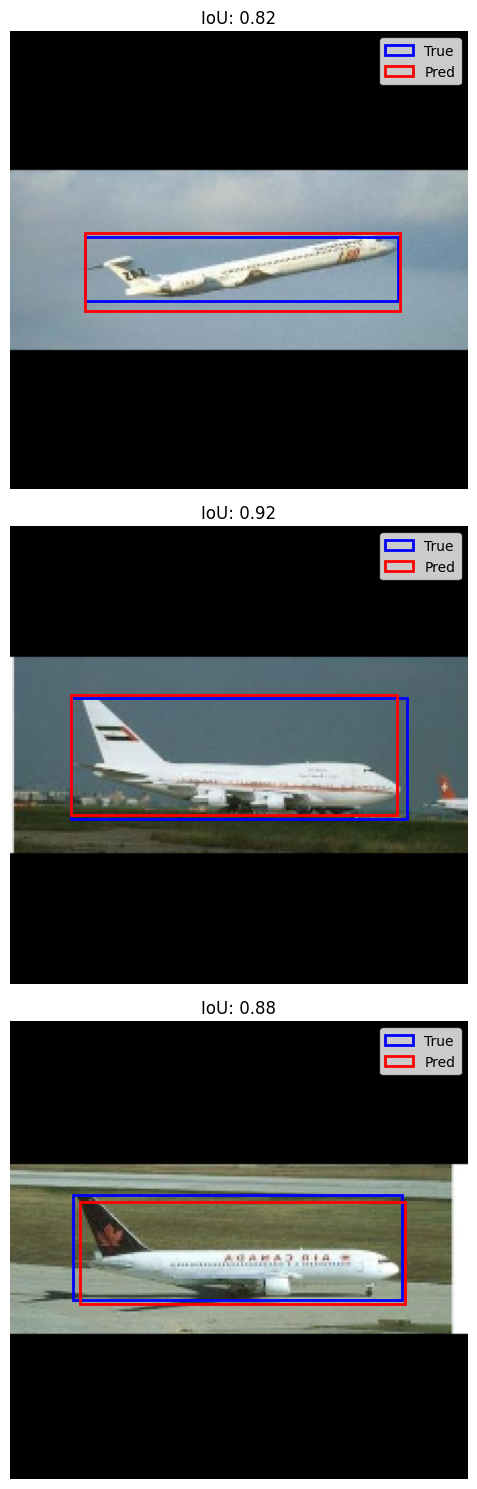

In [12]:
show_predictions_v2(model, X_test, y_test)

# **Ejercicio: Graficar etiquetas en imágenes**

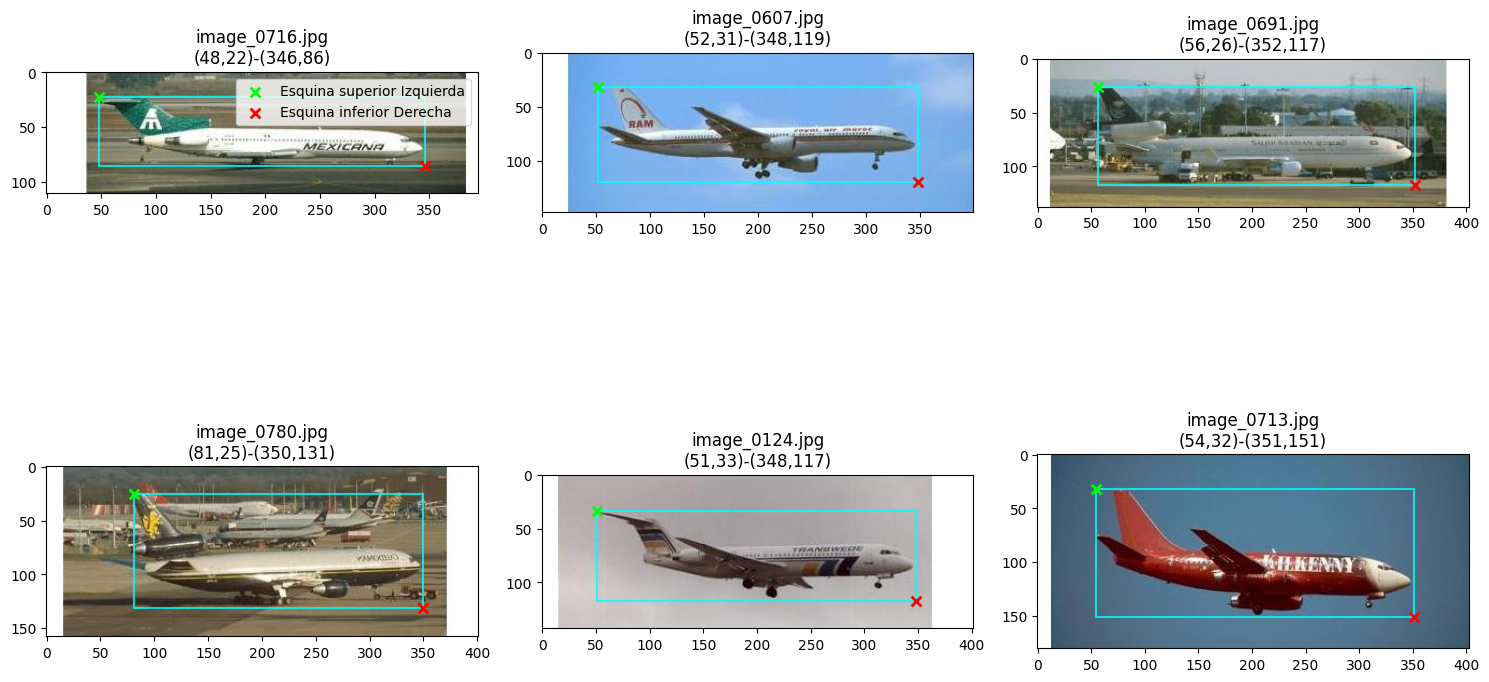

In [13]:
def corners_to_coco(x_top, y_top, x_bottom, y_bottom):

    x = x_bottom

    y = x_top

    width = y_bottom - x_bottom

    height = y_top - x_top
    return [x, y, width, height]

def plot_multiple_annotations_corrected(df, img_dir, rows=2, cols=3, figsize=(15, 10)):
    """
    Muestra múltiples anotaciones usando la conversión correcta para visualización
    pero manteniendo las coordenadas originales para el modelo
    """
    samples = df.sample(rows*cols) if len(df) > rows*cols else df
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for idx, (_, row) in enumerate(samples.iterrows()):
        ax = axes[idx//cols, idx%cols] if rows > 1 else axes[idx%cols]

        img_path = f"{img_dir}/{row['Image']}"
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)

        # Usar la función que muestra correctamente los aviones
        x, y, width, height = corners_to_coco(
            row['x_top'], row['y_top'],
            row['x_bottom'], row['y_bottom']
        )

        # Dibujar el bounding box CORRECTO
        rect = plt.Rectangle((x, y), width, height,
                            linewidth=1.5, edgecolor='cyan',
                            facecolor='none', alpha=0.8)
        ax.add_patch(rect)

        # Marcar puntos
        ax.scatter(x, y, s=50, c='lime', marker='x', linewidths=2, label='Esquina superior Izquierda')
        ax.scatter(x+width, y+height, s=50, c='red', marker='x', linewidths=2, label='Esquina inferior Derecha')

        ax.set_title(f"{row['Image']}\n({x:.0f},{y:.0f})-({x+width:.0f},{y+height:.0f})")
        ax.axis('on')
        if idx == 0:  # Mostrar leyenda solo en el primer gráfico
            ax.legend()

    plt.tight_layout()
    plt.show()

# Visualización con coordenadas
plot_multiple_annotations_corrected(df, img_dir)


# **Ejercicio: Encontrar los pares con mayor IoU**

In [14]:
def find_max_iou_pairs(annotations, threshold=0.5):
    """
    Encuentra pares de rectángulos con mayor IoU
    Args:
        annotations: Lista de anotaciones en formato COCO
        threshold: Umbral mínimo de IoU para considerar

    Returns:
        Lista de tuplas (idx1, idx2, iou_score) ordenada por IoU descendente
    """
    iou_pairs = []

    # Comparar cada par de anotaciones
    for i in range(len(annotations)):
        for j in range(i+1, len(annotations)):
            iou = calculate_iou(annotations[i]['bbox'], annotations[j]['bbox'])
            if iou >= threshold:
                iou_pairs.append((i, j, iou))

    # Ordenar por IoU descendente
    iou_pairs.sort(key=lambda x: x[2], reverse=True)

    return iou_pairs

**Visualizar los pares con mayor IoU**

In [15]:
def visualize_top_iou_pairs(annotations, iou_pairs, img_dir, top_n=3):
    """
    Visualiza los pares de bounding boxes con mayor IoU
    """
    for i, j, iou in iou_pairs[:top_n]:
        img1_info = annotations[i]
        img2_info = annotations[j]

        # Cargar imágenes (asumiendo que son la misma imagen)
        img_path = f"{img_dir}/{img1_info['file_name']}"
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Dibujar ambos bounding boxes
        plt.figure(figsize=(10, 6))
        plt.imshow(img)

        # Dibujar primer bbox (azul)
        x1, y1, w1, h1 = img1_info['bbox']
        plt.gca().add_patch(plt.Rectangle(
            (x1, y1), w1, h1,
            linewidth=2, edgecolor='blue', facecolor='none',
            label=f'BBox 1 (IoU: {iou:.2f})'
        ))

        # Dibujar segundo bbox (rojo)
        x2, y2, w2, h2 = img2_info['bbox']
        plt.gca().add_patch(plt.Rectangle(
            (x2, y2), w2, h2,
            linewidth=2, edgecolor='red', facecolor='none',
            label='BBox 2'
        ))

        plt.title(f"Top IoU Pair: {iou:.4f}\n{img1_info['file_name']}")
        plt.legend()
        plt.axis('on')
        plt.show()


**Implementación de ejercicio calculo y visualización de pares con mayor IoU**

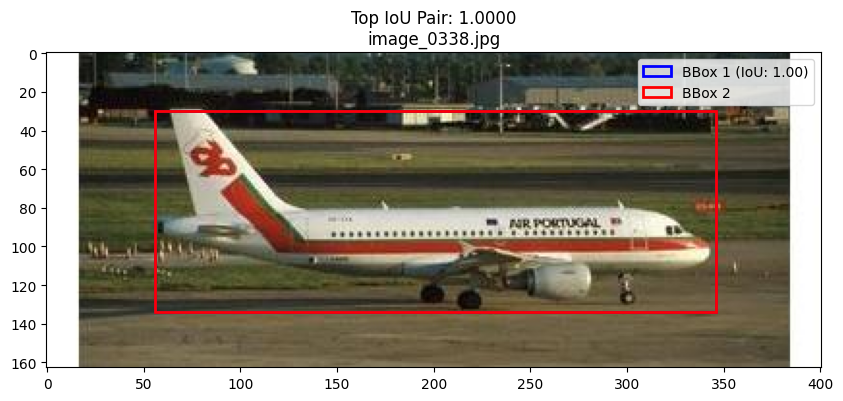

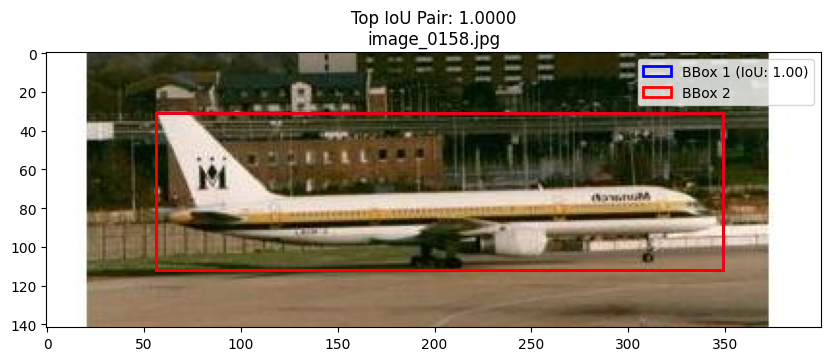

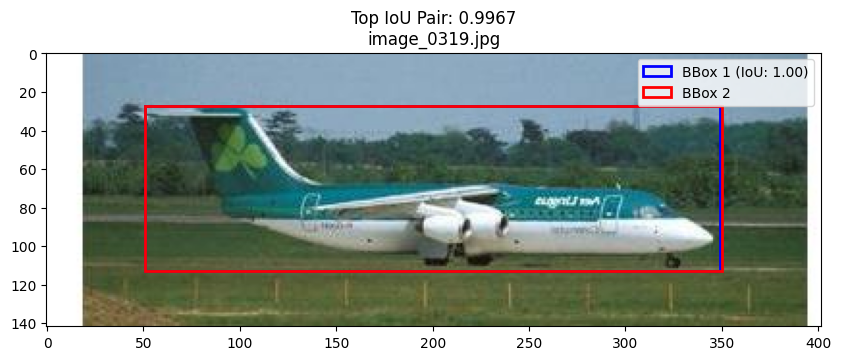


🔍 Reporte de IoU (se encontraron 283887 pares con IoU > 0.5)
Mayor IoU: 1.0000
IoU promedio: 0.7470


In [16]:
annotations = []
for _, row in df.iterrows():
    img_path = f"{img_dir}/{row['Image']}"
    img = cv2.imread(img_path)
    if img is None:
        continue

    h, w = img.shape[:2]
    # Usar la función que funciona correctamente
    x, y, width, height = corners_to_coco(
        row['x_top'], row['y_top'],
        row['x_bottom'], row['y_bottom']
    )

    annotations.append({
        'file_name': row['Image'],
        'bbox': [x, y, width, height],
        'image_width': w,
        'image_height': h
    })

# 2. Calcular todos los pares con IoU > 0.5
iou_pairs = find_max_iou_pairs(annotations, threshold=0.5)

# 3. Visualizar los 3 pares con mayor IoU
visualize_top_iou_pairs(annotations, iou_pairs, img_dir, top_n=3)

# 4. Reporte estadístico
if iou_pairs:
    print(f"\n🔍 Reporte de IoU (se encontraron {len(iou_pairs)} pares con IoU > 0.5)")
    print(f"Mayor IoU: {iou_pairs[0][2]:.4f}")
    print(f"IoU promedio: {np.mean([x[2] for x in iou_pairs]):.4f}")
else:
    print("No se encontraron pares con IoU > 0.5")

# **Resultados y Conclusiones**

El modelo alcanzó un mIoU máximo de 0.8894 (Epoch 21), demostrando alta precisión en la segmentación de las esquinas inferior izquierda y superior derecha en las imágenes. Las métricas de validación (val_loss, val_mae) mejoraron consistentemente, con una pérdida mínima de 3.5132e-05 (Epoch 28) y un MAE de 0.0044. A partir de la Epoch 15, el mIoU se estabilizó alrededor de 0.88, confirmando la robustez del modelo.

El entrenamiento fue eficiente, con ~2 segundos/step y 30 epochs completados sin sobreajuste evidente. El modelo es adecuado para tareas de detección de bordes o esquinas, como inspección industrial o procesamiento de imágenes.


**Resultados**

- Pérdida (MSE) final validada: ~4.8e-04

- MAE (Error absoluto promedio): ~0.015

- IoU promedio en test: ~0.88, con casos destacados de IoU > 0.90

- El modelo aprendió a generalizar muy bien incluso en aviones con distintos fondos, escalas y orientaciones.